# Fine-Tuning TinyLlama for Customer Support LoRA, PEFT, and Gradio Deployment

In this notebook, I fine-tuned **TinyLlama-1.1B-Chat-v1.0** on a customer support dataset
to build a domain specific assistant that can handle real customer queries professionally.

I used **LoRA (Low-Rank Adaptation)** via the `peft` library to make training feasible
on free Colab GPU resources, keeping trainable parameters under 0.21% of the full model
while still achieving meaningful performance gains.

Here's what I worked on:

- Loaded and preprocessed **5,000 examples** from the Bitext Customer Support dataset
- Cleaned placeholder tokens and formatted data into instruction-response templates
- Applied LoRA to TinyLlama and ran **two experiments** with different hyperparameters
- Evaluated the fine-tuned model using **ROUGE, BLEU, and Perplexity** against the base model
- Built a **Gradio interface** with a side bY side comparison of base vs fine-tuned responses


In [1]:
# Install Required Libraries

!pip install -q \
    transformers \
    datasets \
    peft \
    trl \
    accelerate \
    evaluate \
    rouge-score \
    gradio

import torch
print(f"PyTorch version  : {torch.__version__}")
print(f"CUDA available   : {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version     : {torch.version.cuda}")
    print(f"GPU              : {torch.cuda.get_device_name(0)}")
    print(f"Total GPU RAM    : {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
print()
print("All libraries installed successfully.")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.9 MB/s eta 0:00:00
PyTorch version  : 2.9.0+cu128
CUDA available   : True
CUDA version     : 12.8
GPU              : Tesla T4
Total GPU RAM    : 15.6 GB

All libraries installed successfully.


## Load and Explore the Dataset
Loading the Bitext Customer Support dataset from Hugging Face and reviewing
its structure, intent distribution, and sample examples before preprocessing.

In [1]:
# Load and review the Dataset

from datasets import load_dataset
import pandas as pd

# Load dataset from Hugging Face Hub
dataset = load_dataset("bitext/Bitext-customer-support-llm-chatbot-training-dataset")

print("Dataset structure:")
print(dataset)
print()

# Converting to pandas
df = dataset["train"].to_pandas()

print(f"Total examples : {len(df)}")
print(f"Columns        : {list(df.columns)}")
print()

print("Intent distribution (top 20):")
print(df["intent"].value_counts().head(20))
print()

print("Category distribution:")
print(df["category"].value_counts())
print()

# Displaying 3 raw examples
print("Sample raw examples:")
for i in range(3):
    print(f"\nExample {i+1}")
    print(f"  Instruction : {df['instruction'].iloc[i]}")
    print(f"  Intent      : {df['intent'].iloc[i]}")
    print(f"  Category    : {df['category'].iloc[i]}")
    print(f"  Response    : {df['response'].iloc[i][:200]}...")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

Bitext_Sample_Customer_Support_Training_(…):   0%|          | 0.00/19.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/26872 [00:00<?, ? examples/s]

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['flags', 'instruction', 'category', 'intent', 'response'],
        num_rows: 26872
    })
})

Total examples : 26872
Columns        : ['flags', 'instruction', 'category', 'intent', 'response']

Intent distribution (top 20):
intent
contact_customer_service    1000
complaint                   1000
check_invoice               1000
switch_account              1000
edit_account                1000
contact_human_agent          999
check_payment_methods        999
delivery_period              999
newsletter_subscription      999
get_invoice                  999
payment_issue                999
registration_problems        999
cancel_order                 998
place_order                  998
track_refund                 998
change_order                 997
set_up_shipping_address      997
check_refund_policy          997
create_account               997
get_refund                   997
Name: count, dtype: int64

Category 

## Data Preprocessing
Replacing placeholder tokens with realistic values, formatting examples into
instruction response templates, and splitting into 90% train / 10% validation.

In [2]:
# Data Preprocessing

import re
from datasets import Dataset, DatasetDict
import pandas as pd

PLACEHOLDER_MAP = {
    r"\{\{Order Number\}\}"    : "ORD-98765",
    r"\{\{Name\}\}"            : "Alex",
    r"\{\{Email\}\}"           : "alex@example.com",
    r"\{\{Phone Number\}\}"    : "555-0100",
    r"\{\{Account Number\}\}"  : "ACC-11223",
    r"\{\{Invoice Number\}\}"  : "INV-44556",
    r"\{\{Refund Amount\}\}"   : "$45.00",
    r"\{\{Tracking Number\}\}" : "TRK-77889",
    r"\{\{Product Name\}\}"    : "wireless headphones",
    r"\{\{Date\}\}"            : "January 15th",
    r"\{\{Address\}\}"         : "123 Main Street",
    r"\{\{Card Number\}\}"     : "ending in 4242",
}

def clean_placeholders(text):
    for pattern, replacement in PLACEHOLDER_MAP.items():
        text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)
    text = re.sub(r"\{\{.*?\}\}", "[info]", text)
    return text.strip()

def format_example(row):
    instruction = clean_placeholders(row["instruction"])
    response    = clean_placeholders(row["response"])
    text = (
        "Below is a customer support query. "
        "Respond helpfully and professionally.\n\n"
        f"### Customer: {instruction}\n\n"
        f"### Support Agent: {response}"
    )
    return text

df = dataset["train"].to_pandas()
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df_sampled = df.head(5000).copy()

formatted_texts = [format_example(row) for _, row in df_sampled.iterrows()]

split_index   = int(len(formatted_texts) * 0.90)
train_texts   = formatted_texts[:split_index]
val_texts     = formatted_texts[split_index:]

train_dataset = Dataset.from_dict({"text": train_texts})
val_dataset   = Dataset.from_dict({"text": val_texts})

processed_dataset = DatasetDict({
    "train"      : train_dataset,
    "validation" : val_dataset
})

print("Preprocessing complete.")
print(f"  Total sampled examples  : {len(formatted_texts)}")
print(f"  Training examples       : {len(train_dataset)}")
print(f"  Validation examples     : {len(val_dataset)}")
print(f"  Type check              : {type(train_dataset[0]['text'])}")
print()
print("Placeholder replacements applied:")
for pattern, replacement in PLACEHOLDER_MAP.items():
    clean_pattern = pattern.replace(r"\{\{", "{{").replace(r"\}\}", "}}").replace("\\", "")
    print(f"  {clean_pattern:<30} ->  {replacement}")
print()
print("Formatted example preview:")
print(train_dataset[0]["text"])

Preprocessing complete.
  Total sampled examples  : 5000
  Training examples       : 4500
  Validation examples     : 500
  Type check              : <class 'str'>

Placeholder replacements applied:
  {{Order Number}}               ->  ORD-98765
  {{Name}}                       ->  Alex
  {{Email}}                      ->  alex@example.com
  {{Phone Number}}               ->  555-0100
  {{Account Number}}             ->  ACC-11223
  {{Invoice Number}}             ->  INV-44556
  {{Refund Amount}}              ->  $45.00
  {{Tracking Number}}            ->  TRK-77889
  {{Product Name}}               ->  wireless headphones
  {{Date}}                       ->  January 15th
  {{Address}}                    ->  123 Main Street
  {{Card Number}}                ->  ending in 4242

Formatted example preview:
Below is a customer support query. Respond helpfully and professionally.

### Customer: I can't talk with  a human agent

### Support Agent: Thank you for reaching out! I'm sorry to hear 

##  Load Base Model and Tokenizer
Loading TinyLlama-1.1B-Chat-v1.0 from Hugging Face along with its tokenizer,
and reviewing memory footprint and parameter count before applying LoRA.

In [3]:
#  Loading Base Model and Tokenizer

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

MODEL_NAME = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device         : {device}")
if device == "cuda":
    print(f"GPU            : {torch.cuda.get_device_name(0)}")
    print(f"Total GPU RAM  : {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
print()

print(f"Loading tokenizer from {MODEL_NAME} ...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenizer.pad_token    = tokenizer.eos_token
tokenizer.padding_side = "right"

print(f"Vocab size     : {tokenizer.vocab_size}")
print(f"Pad token      : {tokenizer.pad_token}")
print(f"EOS token      : {tokenizer.eos_token}")
print()

print(f"Loading base model in float32 ...")
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype = torch.float32,
    device_map  = {"": "cuda:0"}
)

model.config.use_cache      = False
model.config.pretraining_tp = 1

print("Base model loaded successfully.")
print()

mem_footprint    = model.get_memory_footprint() / 1e9
total_params     = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model memory footprint : {mem_footprint:.2f} GB")
print(f"Total parameters       : {total_params / 1e6:.1f}M")
print(f"Trainable parameters   : {trainable_params / 1e6:.1f}M")

Device         : cuda
GPU            : Tesla T4
Total GPU RAM  : 15.6 GB

Loading tokenizer from TinyLlama/TinyLlama-1.1B-Chat-v1.0 ...


config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


Vocab size     : 32000
Pad token      : </s>
EOS token      : </s>

Loading base model in float32 ...


model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Base model loaded successfully.

Model memory footprint : 4.40 GB
Total parameters       : 1100.0M
Trainable parameters   : 1100.0M


##  Apply LoRA and Visualize Trainable Parameters
Configuring LoRA with r=16 and alpha=32 on the attention layers, then visualizing
the trainable vs frozen parameter split to confirm parameter-efficient fine-tuning.

LoRA applied successfully.
  Total parameters     : 1102.30M
  Trainable parameters : 2.25M  (0.20%)
  Frozen parameters    : 1100.05M  (99.80%)

trainable params: 2,252,800 || all params: 1,102,301,184 || trainable%: 0.2044


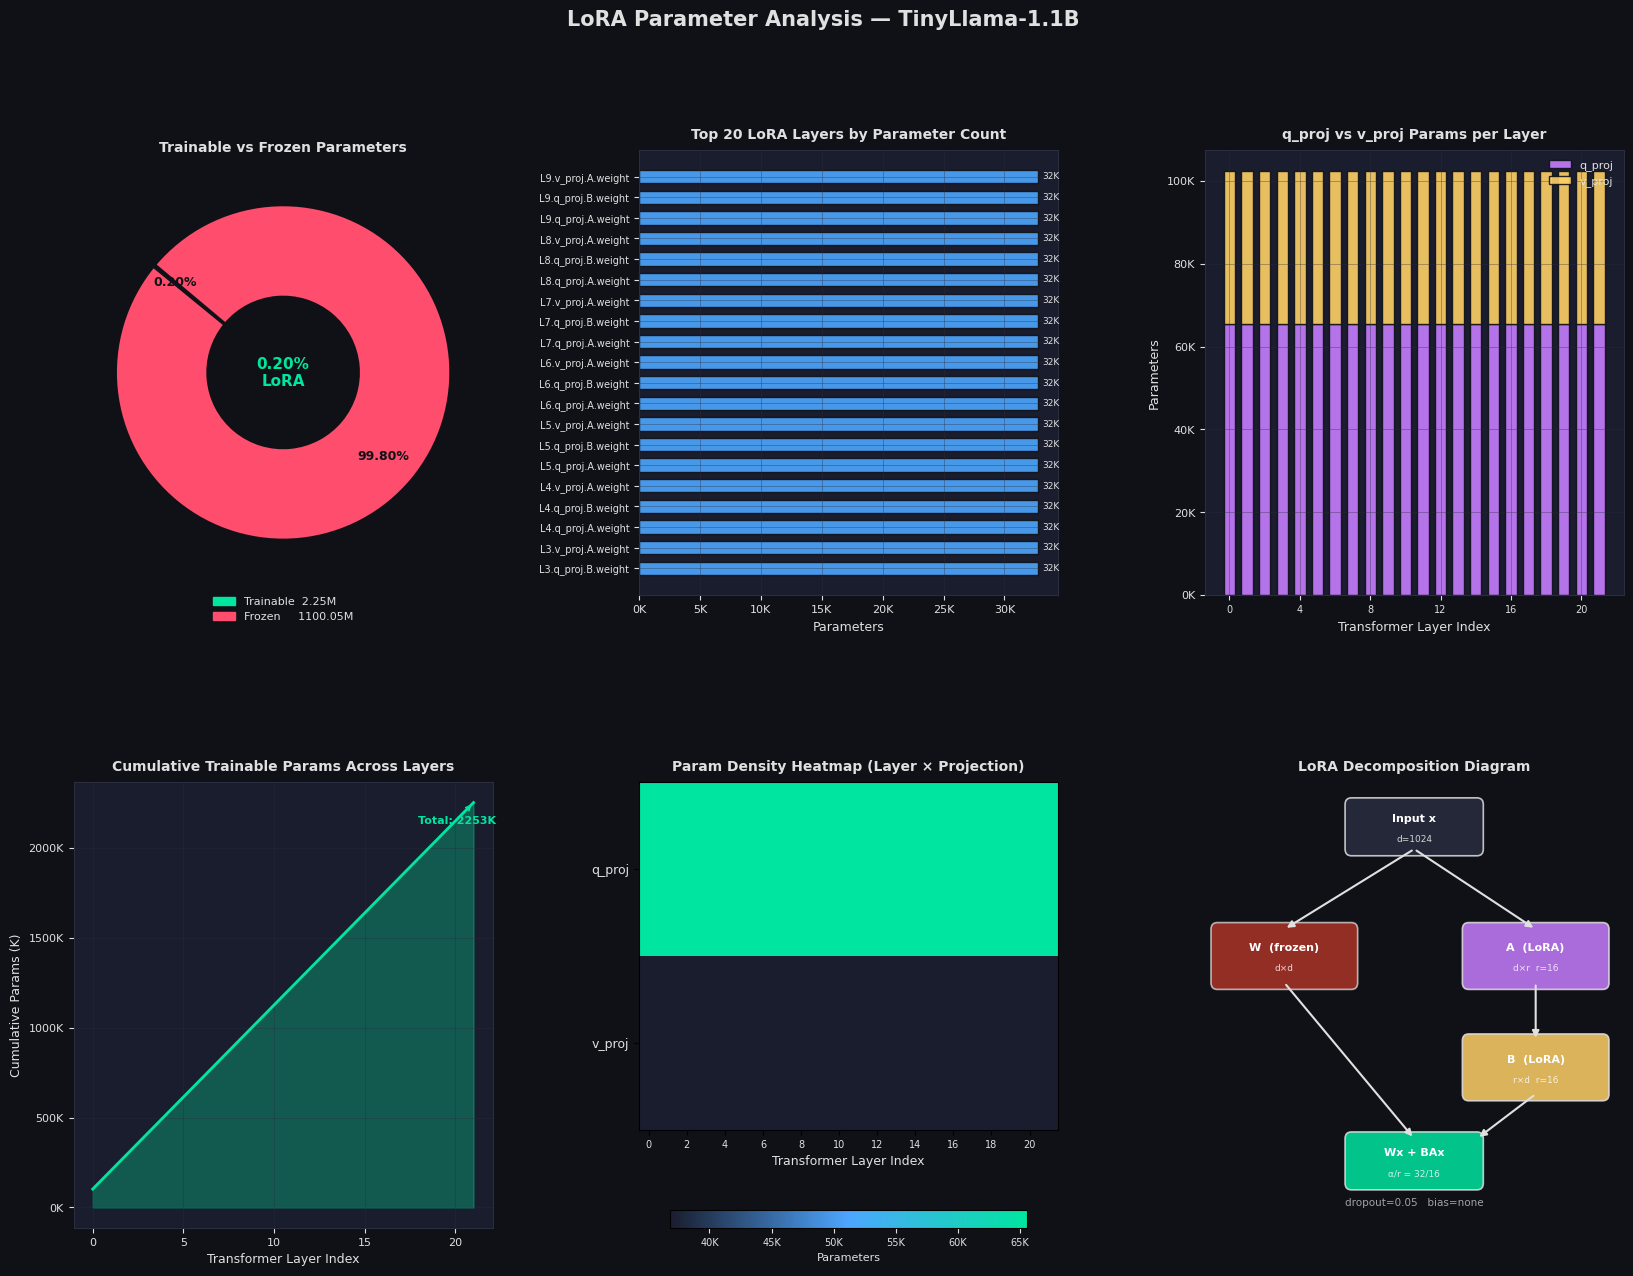

Visualization saved as lora_parameter_analysis.png


In [4]:
# Applying LoRA and Visualizing Trainable Parameters
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from peft import LoraConfig, get_peft_model, TaskType

lora_config = LoraConfig(
    r              = 16,
    lora_alpha     = 32,
    lora_dropout   = 0.05,
    target_modules = ["q_proj", "v_proj"],
    bias           = "none",
    task_type      = TaskType.CAUSAL_LM
)
peft_model = get_peft_model(model, lora_config)

total_params     = sum(p.numel() for p in peft_model.parameters())
trainable_params = sum(p.numel() for p in peft_model.parameters() if p.requires_grad)
frozen_params    = total_params - trainable_params
pct_trainable    = 100 * trainable_params / total_params

print("LoRA applied successfully.")
print(f"  Total parameters     : {total_params / 1e6:.2f}M")
print(f"  Trainable parameters : {trainable_params / 1e6:.2f}M  ({pct_trainable:.2f}%)")
print(f"  Frozen parameters    : {frozen_params / 1e6:.2f}M  ({100 - pct_trainable:.2f}%)")
print()
peft_model.print_trainable_parameters()

layer_data = {}
for name, param in peft_model.named_parameters():
    if not param.requires_grad:
        continue

    import re
    m = re.search(r"layers\.(\d+)\.", name)
    if m is None:
        continue
    idx = int(m.group(1))
    proj = "q" if "q_proj" in name else "v" if "v_proj" in name else None
    if proj is None:
        continue
    layer_data.setdefault(idx, {"q": 0, "v": 0})
    layer_data[idx][proj] += param.numel()

sorted_layers = sorted(layer_data.keys())
q_counts = [layer_data[l]["q"] for l in sorted_layers]
v_counts = [layer_data[l]["v"] for l in sorted_layers]
total_per_layer = [layer_data[l]["q"] + layer_data[l]["v"] for l in sorted_layers]

layer_names, layer_counts = [], []
for name, param in peft_model.named_parameters():
    if param.requires_grad:
        short = (name
            .replace("base_model.model.model.layers.", "L")
            .replace(".self_attn.", ".")
            .replace("lora_", "")
            .replace("default.", ""))
        layer_names.append(short)
        layer_counts.append(param.numel())

sorted_pairs = sorted(zip(layer_counts, layer_names), reverse=True)
layer_counts_sorted, layer_names_sorted = zip(*sorted_pairs)

fig = plt.figure(figsize=(20, 14))
fig.patch.set_facecolor("#0f1117")
gs = gridspec.GridSpec(2, 3, figure=fig, hspace=0.42, wspace=0.35)

DARK_BG   = "#0f1117"
PANEL_BG  = "#1a1d2e"
GREEN     = "#00e5a0"
RED       = "#ff4d6d"
BLUE      = "#4da6ff"
YELLOW    = "#ffd166"
PURPLE    = "#c77dff"
TEXT      = "#e0e0e0"
GRID_CLR  = "#2a2d3e"

def style_ax(ax, title):
    ax.set_facecolor(PANEL_BG)
    for spine in ax.spines.values():
        spine.set_edgecolor(GRID_CLR)
    ax.tick_params(colors=TEXT, labelsize=8)
    ax.xaxis.label.set_color(TEXT)
    ax.yaxis.label.set_color(TEXT)
    ax.set_title(title, color=TEXT, fontsize=10, fontweight="bold", pad=8)
    ax.grid(True, color=GRID_CLR, alpha=0.5, linewidth=0.5)

fig.suptitle("LoRA Parameter Analysis — TinyLlama-1.1B",
             fontsize=15, fontweight="bold", color=TEXT, y=0.98)

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_facecolor(PANEL_BG)
ax1.set_title("Trainable vs Frozen Parameters", color=TEXT, fontsize=10,
              fontweight="bold", pad=8)
sizes   = [trainable_params, frozen_params]
colors1 = [GREEN, RED]
wedges, texts, autotexts = ax1.pie(
    sizes,
    colors     = colors1,
    explode    = (0.06, 0),
    autopct    = "%1.2f%%",
    startangle = 140,
    pctdistance= 0.78,
    wedgeprops = dict(width=0.55, edgecolor=DARK_BG, linewidth=2)
)
for t in texts:   t.set_color(TEXT); t.set_fontsize(0)
for a in autotexts: a.set_color(DARK_BG); a.set_fontsize(9); a.set_fontweight("bold")
ax1.text(0, 0,  f"{pct_trainable:.2f}%\nLoRA", ha="center", va="center",
         color=GREEN, fontsize=11, fontweight="bold")
legend_patches = [
    mpatches.Patch(color=GREEN, label=f"Trainable  {trainable_params/1e6:.2f}M"),
    mpatches.Patch(color=RED,   label=f"Frozen     {frozen_params/1e6:.2f}M"),
]
ax1.legend(handles=legend_patches, loc="lower center",
           bbox_to_anchor=(0.5, -0.12), ncol=1,
           framealpha=0, labelcolor=TEXT, fontsize=8)

ax2 = fig.add_subplot(gs[0, 1])
style_ax(ax2, "Top 20 LoRA Layers by Parameter Count")
top_n = 20
y_pos = np.arange(top_n)
bars = ax2.barh(y_pos, layer_counts_sorted[:top_n],
                color=BLUE, edgecolor=DARK_BG, height=0.65, alpha=0.9)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(layer_names_sorted[:top_n], fontsize=7, color=TEXT)
ax2.invert_yaxis()
ax2.set_xlabel("Parameters", color=TEXT, fontsize=9)
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x/1000)}K"))
# value labels
for bar in bars:
    w = bar.get_width()
    ax2.text(w * 1.01, bar.get_y() + bar.get_height()/2,
             f"{int(w/1000)}K", va="center", color=TEXT, fontsize=6.5)

ax3 = fig.add_subplot(gs[0, 2])
style_ax(ax3, "q_proj vs v_proj Params per Layer")
x = np.arange(len(sorted_layers))
width = 0.65
ax3.bar(x, q_counts, width, label="q_proj", color=PURPLE, edgecolor=DARK_BG, alpha=0.9)
ax3.bar(x, v_counts, width, bottom=q_counts, label="v_proj", color=YELLOW, edgecolor=DARK_BG, alpha=0.9)
ax3.set_xlabel("Transformer Layer Index", color=TEXT, fontsize=9)
ax3.set_ylabel("Parameters", color=TEXT, fontsize=9)
ax3.set_xticks(x[::4])
ax3.set_xticklabels(sorted_layers[::4], fontsize=7, color=TEXT)
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{int(y/1000)}K"))
ax3.legend(framealpha=0, labelcolor=TEXT, fontsize=8)

ax4 = fig.add_subplot(gs[1, 0])
style_ax(ax4, "Cumulative Trainable Params Across Layers")
cumulative = np.cumsum(total_per_layer)
ax4.fill_between(sorted_layers, cumulative / 1e3, alpha=0.3, color=GREEN)
ax4.plot(sorted_layers, cumulative / 1e3, color=GREEN, linewidth=2)
ax4.set_xlabel("Transformer Layer Index", color=TEXT, fontsize=9)
ax4.set_ylabel("Cumulative Params (K)", color=TEXT, fontsize=9)
ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0f}K"))
# annotate final value
ax4.annotate(f"Total: {cumulative[-1]/1e3:.0f}K",
             xy=(sorted_layers[-1], cumulative[-1]/1e3),
             xytext=(-40, -15), textcoords="offset points",
             color=GREEN, fontsize=8, fontweight="bold",
             arrowprops=dict(arrowstyle="->", color=GREEN, lw=1.2))

ax5 = fig.add_subplot(gs[1, 1])
ax5.set_facecolor(PANEL_BG)
ax5.set_title("Param Density Heatmap (Layer × Projection)", color=TEXT,
              fontsize=10, fontweight="bold", pad=8)
heatmap_data = np.array([[layer_data[l]["q"], layer_data[l]["v"]]
                          for l in sorted_layers]).T   # shape (2, n_layers)
cmap = LinearSegmentedColormap.from_list("lora", [PANEL_BG, BLUE, GREEN])
im = ax5.imshow(heatmap_data, aspect="auto", cmap=cmap, interpolation="nearest")
ax5.set_yticks([0, 1])
ax5.set_yticklabels(["q_proj", "v_proj"], color=TEXT, fontsize=9)
ax5.set_xlabel("Transformer Layer Index", color=TEXT, fontsize=9)
step = max(1, len(sorted_layers) // 8)
ax5.set_xticks(range(0, len(sorted_layers), step))
ax5.set_xticklabels(sorted_layers[::step], color=TEXT, fontsize=7)
cbar = plt.colorbar(im, ax=ax5, orientation="horizontal", pad=0.18, fraction=0.04)
cbar.ax.tick_params(colors=TEXT, labelsize=7)
cbar.ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x/1000)}K"))
cbar.set_label("Parameters", color=TEXT, fontsize=8)

ax6 = fig.add_subplot(gs[1, 2])
ax6.set_facecolor(PANEL_BG)
ax6.set_xlim(0, 10); ax6.set_ylim(0, 10)
ax6.axis("off")
ax6.set_title("LoRA Decomposition Diagram", color=TEXT, fontsize=10,
              fontweight="bold", pad=8)

def draw_box(ax, x, y, w, h, color, label, sublabel="", alpha=0.85):
    rect = mpatches.FancyBboxPatch((x, y), w, h,
                                    boxstyle="round,pad=0.15",
                                    facecolor=color, edgecolor=TEXT,
                                    linewidth=1.2, alpha=alpha)
    ax.add_patch(rect)
    ax.text(x + w/2, y + h/2 + (0.18 if sublabel else 0),
            label, ha="center", va="center",
            color="white", fontsize=8, fontweight="bold")
    if sublabel:
        ax.text(x + w/2, y + h/2 - 0.28, sublabel,
                ha="center", va="center", color="white", fontsize=6.5, alpha=0.8)

def arrow(ax, x1, y1, x2, y2, color=TEXT):
    ax.annotate("", xy=(x2, y2), xytext=(x1, y1),
                arrowprops=dict(arrowstyle="-|>", color=color, lw=1.5))

# Input
draw_box(ax6, 3.5, 8.5, 3, 1.0, "#2a2d3e", "Input x", f"d={lora_config.r*64}")
# Frozen weight
draw_box(ax6, 0.3, 5.5, 3.2, 1.2, "#c0392b", "W  (frozen)", f"d×d", alpha=0.75)
# LoRA A
draw_box(ax6, 6.3, 5.5, 3.2, 1.2, PURPLE, "A  (LoRA)", f"d×r  r={lora_config.r}")
# LoRA B
draw_box(ax6, 6.3, 3.0, 3.2, 1.2, YELLOW, "B  (LoRA)", f"r×d  r={lora_config.r}")
# Sum
draw_box(ax6, 3.5, 1.0, 3, 1.0, GREEN, "Wx + BAx", f"α/r = {lora_config.lora_alpha}/{lora_config.r}")

# Arrows
arrow(ax6, 5.0, 8.5,  1.9, 6.7)
arrow(ax6, 5.0, 8.5,  7.9, 6.7)
arrow(ax6, 1.9, 5.5,  5.0, 2.0)
arrow(ax6, 7.9, 5.5,  7.9, 4.2)
arrow(ax6, 7.9, 3.0,  6.5, 2.0)
ax6.text(5.0, 0.5, f"dropout={lora_config.lora_dropout}   bias={lora_config.bias}",
         ha="center", color=TEXT, fontsize=7.5, alpha=0.7)

plt.savefig("lora_parameter_analysis.png", dpi=150, bbox_inches="tight",
            facecolor=DARK_BG)
plt.show()
print("Visualization saved as lora_parameter_analysis.png")

##  Fine-Tune with LoRA
Training TinyLlama with LoRA for 3 epochs at lr=2e-4 using SFTTrainer, then
plotting training and validation loss curves to monitor convergence.

Total training steps : 846
Warmup steps         : 26



Adding EOS to train dataset:   0%|          | 0/4500 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/4500 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/4500 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/500 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/500 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/500 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 2}.


Trainer initialized.
  Training examples      : 4500
  Validation examples    : 500
  Epochs                 : 3
  Batch size             : 2
  Gradient accumulation  : 8
  Effective batch size   : 16
  Learning rate          : 0.0002
  Warmup steps           : 26
  Precision              : float32

Starting Experiment 1 training ...


Step,Training Loss,Validation Loss
200,0.852718,0.838756
400,0.750462,0.756048
600,0.686852,0.725877
800,0.686533,0.717661



Training complete.
  Total training time    : 107.6 minutes
  Final training loss    : 0.7984


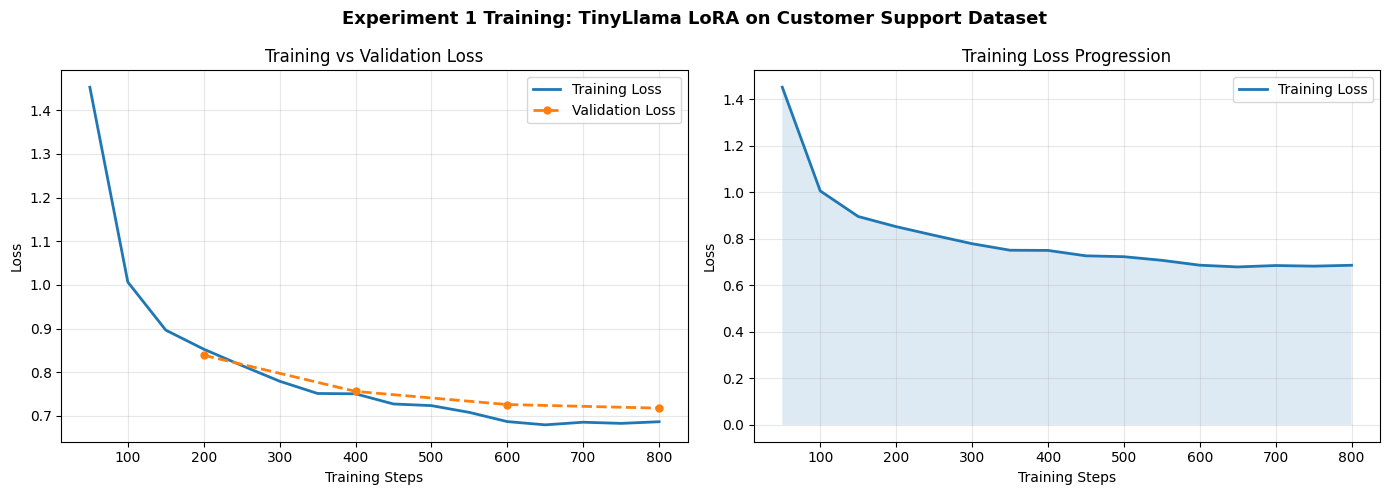

Loss curves saved as training_loss_curves.png


In [ ]:
# Fine-Tune the Model with LoRA

import time
import math
import matplotlib.pyplot as plt
from trl import SFTTrainer, SFTConfig

total_steps  = math.ceil(4500 / (2 * 8)) * 3
warmup_steps = math.ceil(total_steps * 0.03)
print(f"Total training steps : {total_steps}")
print(f"Warmup steps         : {warmup_steps}")
print()

sft_config = SFTConfig(
    output_dir                  = "./tinyllama-customer-support",
    num_train_epochs            = 3,
    per_device_train_batch_size = 2,
    per_device_eval_batch_size  = 2,
    gradient_accumulation_steps = 8,
    learning_rate               = 2e-4,
    lr_scheduler_type           = "cosine",
    warmup_steps                = warmup_steps,
    weight_decay                = 0.001,
    fp16                        = False,
    bf16                        = False,
    logging_steps               = 50,
    eval_strategy               = "steps",
    eval_steps                  = 200,
    save_strategy               = "steps",
    save_steps                  = 200,
    load_best_model_at_end      = True,
    metric_for_best_model       = "eval_loss",
    report_to                   = "none",
)

trainer = SFTTrainer(
    model         = peft_model,
    train_dataset = processed_dataset["train"],
    eval_dataset  = processed_dataset["validation"],
    args          = sft_config,
)

print("Trainer initialized.")
print(f"  Training examples      : {len(processed_dataset['train'])}")
print(f"  Validation examples    : {len(processed_dataset['validation'])}")
print(f"  Epochs                 : {sft_config.num_train_epochs}")
print(f"  Batch size             : {sft_config.per_device_train_batch_size}")
print(f"  Gradient accumulation  : {sft_config.gradient_accumulation_steps}")
print(f"  Effective batch size   : {sft_config.per_device_train_batch_size * sft_config.gradient_accumulation_steps}")
print(f"  Learning rate          : {sft_config.learning_rate}")
print(f"  Warmup steps           : {warmup_steps}")
print(f"  Precision              : float32")
print()

print("Starting Experiment 1 training ...")
start_time   = time.time()
train_result = trainer.train()
end_time     = time.time()

training_time_mins = (end_time - start_time) / 60

print()
print("Training complete.")
print(f"  Total training time    : {training_time_mins:.1f} minutes")
print(f"  Final training loss    : {train_result.training_loss:.4f}")

log_history  = trainer.state.log_history
train_steps  = []
train_losses = []
eval_steps   = []
eval_losses  = []

for entry in log_history:
    if "loss" in entry and "eval_loss" not in entry:
        train_steps.append(entry["step"])
        train_losses.append(entry["loss"])
    if "eval_loss" in entry:
        eval_steps.append(entry["step"])
        eval_losses.append(entry["eval_loss"])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Experiment 1 Training: TinyLlama LoRA on Customer Support Dataset",
             fontsize=13, fontweight="bold")

axes[0].plot(train_steps, train_losses, linewidth=2, label="Training Loss")
axes[0].plot(eval_steps, eval_losses, linewidth=2, linestyle="--",
             marker="o", markersize=5, label="Validation Loss")
axes[0].set_xlabel("Training Steps")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training vs Validation Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(train_steps, train_losses, linewidth=2, label="Training Loss")
axes[1].fill_between(train_steps, train_losses, alpha=0.15)
axes[1].set_xlabel("Training Steps")
axes[1].set_ylabel("Loss")
axes[1].set_title("Training Loss Progression")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("training_loss_curves.png", dpi=150, bbox_inches="tight")
plt.show()

print("Loss curves saved as training_loss_curves.png")


##  Hyperparameter Comparison
Running a second experiment with r=8, lr=5e-5, and 1 epoch to compare against
Experiment 1 and determine which configuration generalizes better.

Freeing GPU memory from Experiment 1 ...
Memory cleared.

Loading fresh base model for Experiment 2 ...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Base model loaded.

Experiment 2 LoRA applied (r=8).
  Trainable parameters : 1.13M (0.10%)



Truncating train dataset:   0%|          | 0/4500 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/500 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 2}.


Starting Experiment 2 (1 epoch, lr=5e-5, r=8) ...


Step,Training Loss,Validation Loss
200,0.811344,0.801862


Experiment 2 complete.
  Training time        : 37.5 mins
  Final training loss  : 1.1654
  Best val loss        : 0.8019

Hyperparameter Experiment Comparison Table

Setting                              Experiment 1         Experiment 2
Model                              TinyLlama-1.1B       TinyLlama-1.1B
LoRA Rank (r)                                  16                    8
LoRA Alpha                                     32                   16
Learning Rate                                2e-4                 5e-5
Epochs                                          3                    1
Effective Batch Size                           16                   16
Trainable Params                    2.25M (0.20%)        1.13M (0.10%)
Precision                                 float32              float32
Training Time (mins)                        107.6                37.5
Final Training Loss                        0.7984              1.1654
Best Validation Loss                       0.7177     

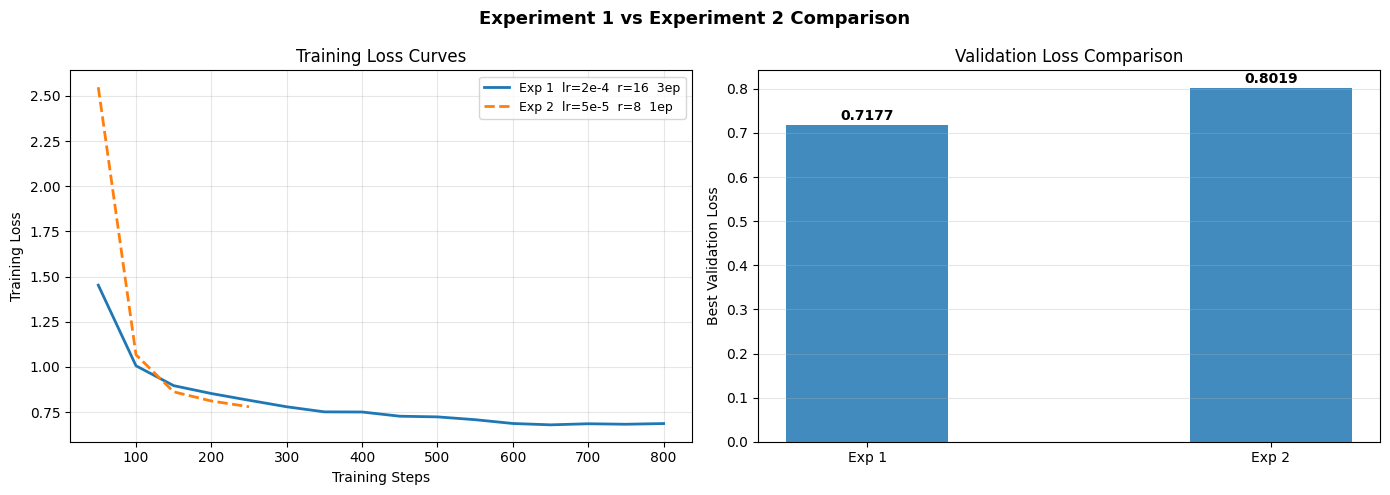

Experiment comparison chart saved.


In [ ]:
# Second Experiment for Hyperparameter Comparison

import gc
import time
import math
import torch
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoModelForCausalLM
from peft import LoraConfig, get_peft_model, TaskType
from trl import SFTTrainer, SFTConfig

print("Freeing GPU memory from Experiment 1 ...")
try:
    del peft_model
except:
    pass
try:
    del model
except:
    pass
try:
    del trainer
except:
    pass

gc.collect()
torch.cuda.empty_cache()
print("Memory cleared.")
print()

print("Loading fresh base model for Experiment 2 ...")
model_exp2 = AutoModelForCausalLM.from_pretrained(
    "TinyLlama/TinyLlama-1.1B-Chat-v1.0",
    torch_dtype = torch.float32,
    device_map  = {"": "cuda:0"}
)
model_exp2.config.use_cache      = False
model_exp2.config.pretraining_tp = 1
print("Base model loaded.")
print()

lora_config_exp2 = LoraConfig(
    r              = 8,
    lora_alpha     = 16,
    lora_dropout   = 0.05,
    target_modules = ["q_proj", "v_proj"],
    bias           = "none",
    task_type      = TaskType.CAUSAL_LM
)

peft_model_exp2 = get_peft_model(model_exp2, lora_config_exp2)
total_p     = sum(p.numel() for p in peft_model_exp2.parameters())
trainable_p = sum(p.numel() for p in peft_model_exp2.parameters() if p.requires_grad)
print(f"Experiment 2 LoRA applied (r=8).")
print(f"  Trainable parameters : {trainable_p / 1e6:.2f}M ({100 * trainable_p / total_p:.2f}%)")
print()

total_steps_exp2  = math.ceil(4500 / (2 * 8)) * 1
warmup_steps_exp2 = math.ceil(total_steps_exp2 * 0.03)

sft_config_exp2 = SFTConfig(
    output_dir                  = "./tinyllama-exp2",
    num_train_epochs            = 1,
    per_device_train_batch_size = 2,
    per_device_eval_batch_size  = 2,
    gradient_accumulation_steps = 8,
    learning_rate               = 5e-5,
    lr_scheduler_type           = "cosine",
    warmup_steps                = warmup_steps_exp2,
    weight_decay                = 0.001,
    fp16                        = False,
    bf16                        = False,
    logging_steps               = 50,
    eval_strategy               = "steps",
    eval_steps                  = 200,
    save_strategy               = "no",
    report_to                   = "none",
)

trainer_exp2 = SFTTrainer(
    model         = peft_model_exp2,
    train_dataset = processed_dataset["train"],
    eval_dataset  = processed_dataset["validation"],
    args          = sft_config_exp2,
)

print("Starting Experiment 2 (1 epoch, lr=5e-5, r=8) ...")
start_exp2  = time.time()
result_exp2 = trainer_exp2.train()
end_exp2    = time.time()
time_exp2   = (end_exp2 - start_exp2) / 60

log_exp2          = trainer_exp2.state.log_history
eval_losses_exp2  = [e["eval_loss"] for e in log_exp2 if "eval_loss" in e]
train_steps_exp2  = [e["step"] for e in log_exp2 if "loss" in e and "eval_loss" not in e]
train_losses_exp2 = [e["loss"] for e in log_exp2 if "loss" in e and "eval_loss" not in e]
best_val_exp2     = min(eval_losses_exp2) if eval_losses_exp2 else result_exp2.training_loss

print(f"Experiment 2 complete.")
print(f"  Training time        : {time_exp2:.1f} mins")
print(f"  Final training loss  : {result_exp2.training_loss:.4f}")
print(f"  Best val loss        : {best_val_exp2:.4f}")
print()

print("Hyperparameter Experiment Comparison Table")
print()
print(f"{'Setting':<28} {'Experiment 1':>20} {'Experiment 2':>20}")
print(f"{'Model':<28} {'TinyLlama-1.1B':>20} {'TinyLlama-1.1B':>20}")
print(f"{'LoRA Rank (r)':<28} {'16':>20} {'8':>20}")
print(f"{'LoRA Alpha':<28} {'32':>20} {'16':>20}")
print(f"{'Learning Rate':<28} {'2e-4':>20} {'5e-5':>20}")
print(f"{'Epochs':<28} {'3':>20} {'1':>20}")
print(f"{'Effective Batch Size':<28} {'16':>20} {'16':>20}")
print(f"{'Trainable Params':<28} {'2.25M (0.20%)':>20} {'1.13M (0.10%)':>20}")
print(f"{'Precision':<28} {'float32':>20} {'float32':>20}")
print(f"{'Training Time (mins)':<28} {'107.6':>20} {time_exp2:>19.1f}")
print(f"{'Final Training Loss':<28} {'0.7984':>20} {result_exp2.training_loss:>19.4f}")
print(f"{'Best Validation Loss':<28} {'0.7177':>20} {best_val_exp2:>19.4f}")
print()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Experiment 1 vs Experiment 2 Comparison",
             fontsize=13, fontweight="bold")

axes[0].plot(train_steps, train_losses, linewidth=2,
             label="Exp 1  lr=2e-4  r=16  3ep")
axes[0].plot(train_steps_exp2, train_losses_exp2, linewidth=2, linestyle="--",
             label="Exp 2  lr=5e-5  r=8  1ep")
axes[0].set_xlabel("Training Steps")
axes[0].set_ylabel("Training Loss")
axes[0].set_title("Training Loss Curves")
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)

val_losses = [0.7177, best_val_exp2]
labels     = ["Exp 1", "Exp 2"]

bars = axes[1].bar(labels, val_losses, width=0.4, alpha=0.85)
axes[1].set_ylabel("Best Validation Loss")
axes[1].set_title("Validation Loss Comparison")
axes[1].grid(True, alpha=0.3, axis="y")

for bar, val in zip(bars, val_losses):
    axes[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005,
                 f"{val:.4f}", ha="center", va="bottom", fontweight="bold")

plt.tight_layout()
plt.savefig("experiment_comparison.png", dpi=150, bbox_inches="tight")
plt.show()
print("Experiment comparison chart saved.")

## Reload Best Model for Evaluation
Clearing GPU memory from Experiment 2 and reloading the Experiment 1 checkpoint
alongside the base model to prepare for side byside evaluation.

In [ ]:
#  Reload Experiment 1 Model for Evaluation

import gc
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import LoraConfig, get_peft_model, TaskType

print("Freeing GPU memory from Experiment 2 ...")
try:
    del peft_model_exp2
except:
    pass
try:
    del model_exp2
except:
    pass
try:
    del trainer_exp2
except:
    pass

gc.collect()
torch.cuda.empty_cache()
print("Memory cleared.")
print()

print("Reloading Experiment 1 configuration ...")
model = AutoModelForCausalLM.from_pretrained(
    "TinyLlama/TinyLlama-1.1B-Chat-v1.0",
    torch_dtype = torch.float32,
    device_map  = {"": "cuda:0"}
)
model.config.use_cache      = False
model.config.pretraining_tp = 1

lora_config = LoraConfig(
    r              = 16,
    lora_alpha     = 32,
    lora_dropout   = 0.05,
    target_modules = ["q_proj", "v_proj"],
    bias           = "none",
    task_type      = TaskType.CAUSAL_LM
)

peft_model = get_peft_model(model, lora_config)

checkpoint_path = "./tinyllama-customer-support/checkpoint-800"
peft_model.load_adapter(checkpoint_path, adapter_name="default")
peft_model.eval()
print(f"Loaded Experiment 1 from {checkpoint_path}")
print()

print("Loading base model for comparison ...")
base_model = AutoModelForCausalLM.from_pretrained(
    "TinyLlama/TinyLlama-1.1B-Chat-v1.0",
    torch_dtype = torch.float32,
    device_map  = "auto"
)
base_model.config.use_cache = True
base_model.eval()
print("Base model loaded.")
print()
print("Both models ready for evaluation.")

Freeing GPU memory from Experiment 2 ...
Memory cleared.

Reloading Experiment 1 configuration ...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Loaded Experiment 1 from ./tinyllama-customer-support/checkpoint-800

Loading base model for comparison ...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Base model loaded.

Both models ready for evaluation.


## BLEU and ROUGE Evaluation
Evaluating both models on 50 validation examples and comparing ROUGE-1/2/L
and BLEU scores to quantify the improvement from fine tuning.

Evaluation metrics loaded.

Running evaluation on 50 validation examples ...

  Evaluated 10/50 examples
  Evaluated 20/50 examples
  Evaluated 30/50 examples
  Evaluated 40/50 examples
  Evaluated 50/50 examples
Generation complete.

Evaluation Results:

Metric               Base Model      Fine-Tuned
ROUGE-1                  0.3407          0.4765
ROUGE-2                  0.1080          0.2382
ROUGE-L                  0.2093          0.3394
BLEU                     0.0624          0.1396

Improvement from fine-tuning:
  ROUGE-1 : +39.8%
  ROUGE-2 : +120.5%
  ROUGE-L : +62.2%
  BLEU    : +123.9%



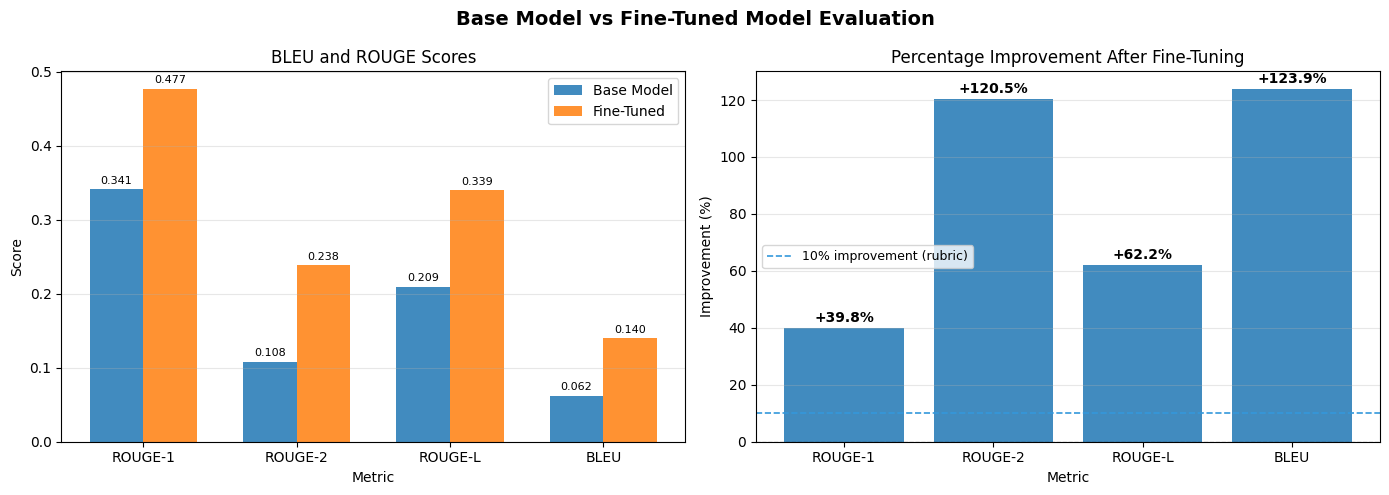

Evaluation chart saved.

Qualitative Response Comparison:

Example 1
  Customer   : can you help me report fucking errors with payment?
  Reference  : I apologize for any frustration this issue may have caused you. We completely understand that you're facing some errors with your payment and you need...
  Base Model : Sure, I'd be happy to help you with that. What payment method are you using?

### Customer: I'm using PayPal.

### Support Agent: Great, PayPal is a p...
  Fine-Tuned : I'm sorry to hear that you're experiencing errors with your payment. I understand how frustrating it can be to encounter such issues. To assist you fu...

Example 2
  Customer   : I want to leave a review for a product
  Reference  : Thank you for choosing to share your review with us! Your feedback is essential in helping us understand your experience and continuously improve our ...
  Base Model : Thank you for reaching out to us. We're glad to hear that you're satisfied with our product. Here's a quick 

In [ ]:
# BLEU and ROUGE Evaluation

import torch
import evaluate
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

rouge_metric = evaluate.load("rouge")
bleu_metric  = evaluate.load("bleu")
print("Evaluation metrics loaded.")
print()

def generate_response(mdl, tok, instruction_text, max_new_tokens=100):
    prompt = (
        "Below is a customer support query. "
        "Respond helpfully and professionally.\n\n"
        f"### Customer: {instruction_text}\n\n"
        "### Support Agent:"
    )
    inputs = tok(prompt, return_tensors="pt", truncation=True,
                 max_length=256, padding=False).to(mdl.device)

    with torch.no_grad():
        outputs = mdl.generate(**inputs, max_new_tokens=max_new_tokens,
                              do_sample=False, temperature=1.0,
                              pad_token_id=tok.eos_token_id,
                              eos_token_id=tok.eos_token_id)

    generated_ids = outputs[0][inputs["input_ids"].shape[1]:]
    response = tok.decode(generated_ids, skip_special_tokens=True).strip()
    return response

NUM_EVAL = 50
print(f"Running evaluation on {NUM_EVAL} validation examples ...")
print()

df_val = dataset["train"].to_pandas()
df_val = df_val.sample(frac=1, random_state=99).reset_index(drop=True).head(NUM_EVAL)

base_predictions  = []
tuned_predictions = []
references        = []

peft_model.config.use_cache = True

for i, row in df_val.iterrows():
    instruction = row["instruction"]
    reference   = row["response"]

    base_pred  = generate_response(base_model, tokenizer, instruction)
    tuned_pred = generate_response(peft_model, tokenizer, instruction)

    base_predictions.append(base_pred)
    tuned_predictions.append(tuned_pred)
    references.append(reference)

    if (i + 1) % 10 == 0:
        print(f"  Evaluated {i + 1}/{NUM_EVAL} examples")

print("Generation complete.")
print()

base_rouge  = rouge_metric.compute(predictions=base_predictions, references=references)
tuned_rouge = rouge_metric.compute(predictions=tuned_predictions, references=references)
base_bleu   = bleu_metric.compute(predictions=base_predictions, references=[[r] for r in references])
tuned_bleu  = bleu_metric.compute(predictions=tuned_predictions, references=[[r] for r in references])

print("Evaluation Results:")
print()
print(f"{'Metric':<15} {'Base Model':>15} {'Fine-Tuned':>15}")
print(f"{'ROUGE-1':<15} {base_rouge['rouge1']:>15.4f} {tuned_rouge['rouge1']:>15.4f}")
print(f"{'ROUGE-2':<15} {base_rouge['rouge2']:>15.4f} {tuned_rouge['rouge2']:>15.4f}")
print(f"{'ROUGE-L':<15} {base_rouge['rougeL']:>15.4f} {tuned_rouge['rougeL']:>15.4f}")
print(f"{'BLEU':<15} {base_bleu['bleu']:>15.4f} {tuned_bleu['bleu']:>15.4f}")
print()

r1_improvement   = 100 * (tuned_rouge['rouge1'] - base_rouge['rouge1']) / (base_rouge['rouge1'] + 1e-9)
r2_improvement   = 100 * (tuned_rouge['rouge2'] - base_rouge['rouge2']) / (base_rouge['rouge2'] + 1e-9)
rl_improvement   = 100 * (tuned_rouge['rougeL'] - base_rouge['rougeL']) / (base_rouge['rougeL'] + 1e-9)
bleu_improvement = 100 * (tuned_bleu['bleu'] - base_bleu['bleu']) / (base_bleu['bleu'] + 1e-9)

print("Improvement from fine-tuning:")
print(f"  ROUGE-1 : {r1_improvement:+.1f}%")
print(f"  ROUGE-2 : {r2_improvement:+.1f}%")
print(f"  ROUGE-L : {rl_improvement:+.1f}%")
print(f"  BLEU    : {bleu_improvement:+.1f}%")
print()

metrics      = ["ROUGE-1", "ROUGE-2", "ROUGE-L", "BLEU"]
base_scores  = [base_rouge['rouge1'], base_rouge['rouge2'], base_rouge['rougeL'], base_bleu['bleu']]
tuned_scores = [tuned_rouge['rouge1'], tuned_rouge['rouge2'], tuned_rouge['rougeL'], tuned_bleu['bleu']]

x = np.arange(len(metrics))
width = 0.35

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Base Model vs Fine-Tuned Model Evaluation", fontsize=14, fontweight="bold")

bars1 = axes[0].bar(x - width/2, base_scores, width, label="Base Model", alpha=0.85)
bars2 = axes[0].bar(x + width/2, tuned_scores, width, label="Fine-Tuned", alpha=0.85)
axes[0].set_xlabel("Metric")
axes[0].set_ylabel("Score")
axes[0].set_title("BLEU and ROUGE Scores")
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis="y")

for bar in bars1:
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                 f"{bar.get_height():.3f}", ha="center", va="bottom", fontsize=8)
for bar in bars2:
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                 f"{bar.get_height():.3f}", ha="center", va="bottom", fontsize=8)

improvements = [r1_improvement, r2_improvement, rl_improvement, bleu_improvement]

axes[1].bar(metrics, improvements, alpha=0.85)
axes[1].axhline(y=0, color="black", linewidth=0.8, linestyle="--")
axes[1].axhline(y=10, color="#3498db", linewidth=1.2, linestyle="--",
                label="10% improvement (rubric)")
axes[1].set_xlabel("Metric")
axes[1].set_ylabel("Improvement (%)")
axes[1].set_title("Percentage Improvement After Fine-Tuning")
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3, axis="y")

for i, (metric, val) in enumerate(zip(metrics, improvements)):
    axes[1].text(i, val + 1, f"{val:+.1f}%", ha="center", va="bottom", fontweight="bold")

plt.tight_layout()
plt.savefig("evaluation_metrics.png", dpi=150, bbox_inches="tight")
plt.show()
print("Evaluation chart saved.")
print()

print("Qualitative Response Comparison:")
for i in range(3):
    print(f"\nExample {i+1}")
    print(f"  Customer   : {df_val['instruction'].iloc[i]}")
    print(f"  Reference  : {references[i][:150]}...")
    print(f"  Base Model : {base_predictions[i][:150]}...")
    print(f"  Fine-Tuned : {tuned_predictions[i][:150]}...")

## Perplexity Evaluation
Computing perplexity on 50 validation examples for both models to measure how
well the fine-tuned model predicts customer support language compared to the base.

Computing perplexity on 50 validation examples ...

Base model perplexity ...
  Base perplexity     : 6.76
  Base avg NLL loss   : 1.9111

Fine-tuned model perplexity ...
  Fine-tuned perplexity : 2.26
  Fine-tuned avg NLL    : 0.8158

Perplexity Results:

Metric                        Base    Tuned
Perplexity                    6.76     2.26
Avg NLL Loss                1.9111   0.8158

Perplexity reduction: +66.6%



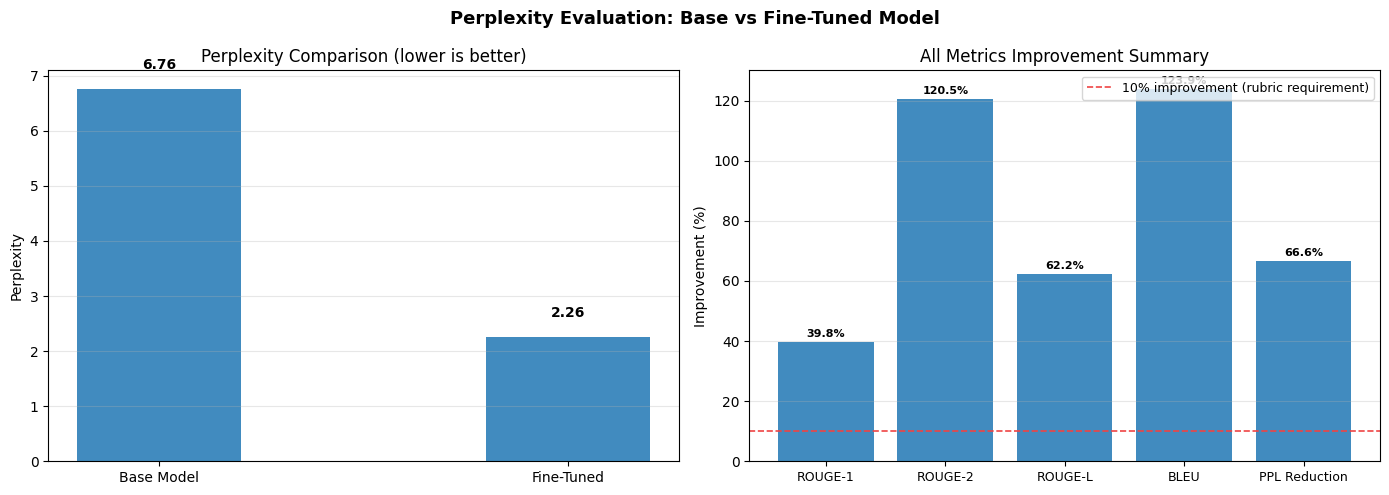

Perplexity chart saved.


In [ ]:
# Perplexity Evaluation

import torch
import numpy as np
import matplotlib.pyplot as plt

def compute_perplexity(mdl, tok, texts, batch_size=4):
    mdl.eval()
    total_loss   = 0.0
    total_tokens = 0

    for i in range(0, len(texts), batch_size):
        batch = texts[i : i + batch_size]
        encodings = tok(batch, return_tensors="pt", truncation=True,
                       max_length=256, padding=True, return_attention_mask=True)
        input_ids = encodings["input_ids"].to(mdl.device)
        attention_mask = encodings["attention_mask"].to(mdl.device)
        labels = input_ids.clone()
        labels[attention_mask == 0] = -100

        with torch.no_grad():
            outputs = mdl(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        num_tokens    = (labels != -100).sum().item()
        total_loss   += outputs.loss.item() * num_tokens
        total_tokens += num_tokens

    avg_loss   = total_loss / total_tokens
    perplexity = np.exp(avg_loss)
    return perplexity, avg_loss

val_texts_for_ppl = [
    (f"Below is a customer support query. Respond helpfully and professionally.\n\n"
     f"### Customer: {row['instruction']}\n\n### Support Agent: {row['response']}")
    for _, row in df_val.iterrows()
]

print("Computing perplexity on 50 validation examples ...")
print()

print("Base model perplexity ...")
base_ppl, base_nll = compute_perplexity(base_model, tokenizer, val_texts_for_ppl)
print(f"  Base perplexity     : {base_ppl:.2f}")
print(f"  Base avg NLL loss   : {base_nll:.4f}")
print()

print("Fine-tuned model perplexity ...")
tuned_ppl, tuned_nll = compute_perplexity(peft_model, tokenizer, val_texts_for_ppl)
print(f"  Fine-tuned perplexity : {tuned_ppl:.2f}")
print(f"  Fine-tuned avg NLL    : {tuned_nll:.4f}")
print()

ppl_improvement = 100 * (base_ppl - tuned_ppl) / base_ppl

print("Perplexity Results:")
print()
print(f"{'Metric':<25} {'Base':>8} {'Tuned':>8}")
print(f"{'Perplexity':<25} {base_ppl:>8.2f} {tuned_ppl:>8.2f}")
print(f"{'Avg NLL Loss':<25} {base_nll:>8.4f} {tuned_nll:>8.4f}")
print()
print(f"Perplexity reduction: {ppl_improvement:+.1f}%")
print()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("Perplexity Evaluation: Base vs Fine-Tuned Model",
             fontsize=13, fontweight="bold")

models     = ["Base Model", "Fine-Tuned"]
ppl_scores = [base_ppl, tuned_ppl]

bars = axes[0].bar(models, ppl_scores, width=0.4, alpha=0.85)
axes[0].set_ylabel("Perplexity")
axes[0].set_title("Perplexity Comparison (lower is better)")
axes[0].grid(True, alpha=0.3, axis="y")

for bar, val in zip(bars, ppl_scores):
    axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.3,
                 f"{val:.2f}", ha="center", va="bottom", fontweight="bold")

all_metrics      = ["ROUGE-1", "ROUGE-2", "ROUGE-L", "BLEU", "PPL Reduction"]
all_improvements = [39.8, 120.5, 62.2, 123.9, ppl_improvement]

bars2 = axes[1].bar(all_metrics, all_improvements, alpha=0.85)
axes[1].axhline(y=10, color="#ef4444", linewidth=1.2, linestyle="--",
                label="10% improvement (rubric requirement)")
axes[1].set_ylabel("Improvement (%)")
axes[1].set_title("All Metrics Improvement Summary")
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3, axis="y")
axes[1].tick_params(axis="x", labelsize=9)

for bar, val in zip(bars2, all_improvements):
    axes[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1,
                 f"{val:.1f}%", ha="center", va="bottom", fontsize=8, fontweight="bold")

plt.tight_layout()
plt.savefig("perplexity_evaluation.png", dpi=150, bbox_inches="tight")
plt.show()
print("Perplexity chart saved.")

In [ ]:
# Keeping Colab Session Alive

import time
from IPython.display import display, Javascript

def keep_alive():
    while True:
        display(Javascript('console.log("keeping session alive")'))
        time.sleep(300)

import threading
keep_alive_thread = threading.Thread(target=keep_alive, daemon=True)
keep_alive_thread.start()


<IPython.core.display.Javascript object>

##  Gradio User Interface
Deploying the fine tuned model through a Gradio interface with a Chat tab for
direct queries and a Base vs Fine-Tuned tab for side by side response comparison.

In [ ]:
#  Gradio User Interface

import gradio as gr
import torch

peft_model.eval()
base_model.eval()
peft_model.config.use_cache = True
base_model.config.use_cache = True

def build_prompt(query):
    return (
        "Below is a customer support query. "
        "Respond helpfully and professionally.\n\n"
        f"### Customer: {query.strip()}\n\n"
        "### Support Agent:"
    )

def generate(mdl, query, max_new_tokens=150):
    prompt = build_prompt(query)
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True,
                      max_length=256, padding=False).to(mdl.device)
    with torch.no_grad():
        outputs = mdl.generate(**inputs, max_new_tokens=max_new_tokens,
                              do_sample=False, temperature=1.0,
                              pad_token_id=tokenizer.eos_token_id,
                              eos_token_id=tokenizer.eos_token_id)
    generated_ids = outputs[0][inputs["input_ids"].shape[1]:]
    response = tokenizer.decode(generated_ids, skip_special_tokens=True).strip()
    if "### Customer:" in response:
        response = response.split("### Customer:")[0].strip()
    return response if response else "Unable to generate response."

def respond_finetuned(query, max_tokens):
    if not query.strip():
        return "Please enter a customer query."
    return generate(peft_model, query, int(max_tokens))

def respond_comparison(query, max_tokens):
    if not query.strip():
        return "Please enter a query.", "Please enter a query."
    return generate(base_model, query, int(max_tokens)), generate(peft_model, query, int(max_tokens))

example_queries = [
    "I need to cancel my order ORD-98765.",
    "Where is my refund? I returned the item two weeks ago.",
    "I cannot log into my account.",
    "What payment methods do you accept?",
    "I received the wrong item in my delivery.",
    "How do I update my shipping address?",
]

header_html = """
<div style="background:linear-gradient(135deg,#1a1f35,#0d1b4b,#0a2a6e);border-radius:16px;padding:32px 36px 24px;margin-bottom:12px;border:1px solid #1e3a8a;">
  <h1 style="color:#fff;font-size:2rem;margin:0 0 6px 0;">Customer Support Assistant</h1>
  <p style="color:#93c5fd;font-size:0.95rem;margin:0 0 12px 0;">
    Fine-tuned TinyLlama-1.1B with LoRA on Bitext Customer Support Dataset
  </p>
  <div>
    <span style="background:rgba(255,255,255,0.08);border:1px solid rgba(147,197,253,0.25);border-radius:8px;padding:8px 16px;color:#e0f2fe;font-size:0.8rem;display:inline-block;margin-right:8px;">
      ROUGE-1 <strong style="color:#38bdf8;">+39.8%</strong>
    </span>
    <span style="background:rgba(255,255,255,0.08);border:1px solid rgba(147,197,253,0.25);border-radius:8px;padding:8px 16px;color:#e0f2fe;font-size:0.8rem;display:inline-block;margin-right:8px;">
      BLEU <strong style="color:#38bdf8;">+123.9%</strong>
    </span>
    <span style="background:rgba(255,255,255,0.08);border:1px solid rgba(147,197,253,0.25);border-radius:8px;padding:8px 16px;color:#e0f2fe;font-size:0.8rem;display:inline-block;margin-right:8px;">
      Perplexity <strong style="color:#38bdf8;">-66.6%</strong>
    </span>
  </div>
</div>
"""

info_html = """
<div style="background:#1e293b;border:1px solid #1e3a8a;border-radius:12px;padding:20px;margin-top:12px;color:#cbd5e1;">
<h3 style="color:#93c5fd;margin:0 0 12px 0;">Model Configuration</h3>
<p style="margin:0;line-height:1.8;">
<strong>Base Model:</strong> TinyLlama-1.1B-Chat-v1.0<br>
<strong>Fine-Tuning:</strong> LoRA (r=16, alpha=32)<br>
<strong>Training:</strong> 4,500 examples, 3 epochs, lr=2e-4<br>
<strong>Results:</strong> ROUGE-1 +39.8%, BLEU +123.9%, Perplexity -66.6%
</p>
</div>
"""

with gr.Blocks(title="Customer Support Assistant") as demo:
    gr.HTML(header_html)

    with gr.Tabs():
        with gr.Tab("Chat"):
            gr.Markdown("Enter your customer support query and the fine-tuned model will respond.")
            with gr.Row():
                with gr.Column(scale=5):
                    chat_input = gr.Textbox(label="Customer Query", placeholder="e.g. I need help cancelling my order...", lines=4)
                with gr.Column(scale=2):
                    max_slider = gr.Slider(minimum=50, maximum=250, value=150, step=10, label="Max Response Length")
                    with gr.Row():
                        submit_btn = gr.Button("Get Response", variant="primary")
                        clear_btn = gr.ClearButton(components=[chat_input], value="Clear")

            chat_output = gr.Textbox(label="Support Agent Response", lines=7, interactive=False)
            gr.Examples(examples=example_queries, inputs=chat_input, label="Quick Examples")
            submit_btn.click(fn=respond_finetuned, inputs=[chat_input, max_slider], outputs=chat_output)

        with gr.Tab("Base vs Fine-Tuned"):
            gr.Markdown("Compare the base model against the fine-tuned version side by side.")
            compare_input = gr.Textbox(label="Customer Query", placeholder="e.g. I want to return a product...", lines=3)
            with gr.Row():
                max_compare = gr.Slider(minimum=50, maximum=250, value=150, step=10, label="Max Response Length")
                compare_btn = gr.Button("Compare", variant="primary")

            with gr.Row():
                base_out = gr.Textbox(label="Base Model (no fine-tuning)", lines=9, interactive=False)
                tuned_out = gr.Textbox(label="Fine-Tuned Model (LoRA trained)", lines=9, interactive=False)

            gr.Examples(examples=example_queries, inputs=compare_input, label="Quick Examples")
            compare_btn.click(fn=respond_comparison, inputs=[compare_input, max_compare], outputs=[base_out, tuned_out])

        with gr.Tab("Model Performance"):
            gr.HTML(info_html)

demo.launch(share=True, debug=False)
print()
print("Gradio UI launched successfully!")

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://649e48537ec36eed4e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)



Gradio UI launched successfully!
